# <font color='orange'>Opinion Detection - Supervised</font>

In [ ]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import nltk
nltk.download('movie_reviews')
import warnings
warnings.filterwarnings('ignore')

### <font color='orange'>Load and Preprocess Data</font>

In [14]:
from nltk.corpus import movie_reviews as mr
from random import shuffle, seed
seed(42)

documents = [(mr.raw(file_id), 1 if category == 'pos' else 0) for category in mr.categories() for file_id in mr.fileids(category)]
shuffle(documents)

In [15]:
df_train, df_test = documents[:1600], documents[1600:]
X_train = [item[0] for item in df_train]
y_train = [item[1] for item in df_train]

X_test = [item[0] for item in df_test]
y_test = [item[1] for item in df_test]

X_train_cleaned = tn.normalize_corpus(X_train)
X_test_cleaned = tn.normalize_corpus(X_test)

### <font color='orange'>Feature Extraction</font>

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
# build BOW features on train reviews
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))
X_train = cv.fit_transform(X_train_cleaned)

# transform test reviews into features
X_test = cv.transform(X_test_cleaned)

print('BOW model:> Train features shape:', X_train.shape, ' Test features shape:', X_test.shape)

BOW model:> Train features shape: (1600, 41931)  Test features shape: (400, 41931)


To work with certain model we need to work with floats

In [20]:
X_train,X_test = X_train.astype('float32'),X_test.astype('float32')

### <font color='orange'>Extended Feature Extraction</font>

In [33]:
from sklearn.preprocessing import StandardScaler

In [19]:
def count_words(text):
    return len(str(text).split())

def count_uniquewords(text):
    return len(set(str(text).split()))

def count_chars(text):
    return len(str(text))

def word_density(text):
    return count_chars(text) / (count_words(text) + 1)

In [34]:
custom_features = pd.DataFrame()
custom_features['word_count'] = [count_words(doc) for doc in X_train_cleaned]
custom_features['unique_word_count'] = [count_uniquewords(doc) for doc in X_train_cleaned]
custom_features['char_count'] = [count_chars(doc) for doc in X_train_cleaned]
custom_features['word_density'] = [word_density(doc) for doc in X_train_cleaned]

sc = StandardScaler()
custom_features = sc.fit_transform(custom_features)

X_train_ext = np.hstack((X_train.toarray(), custom_features))

In [35]:
custom_features_test = pd.DataFrame()
custom_features_test['word_count'] = [count_words(doc) for doc in X_test_cleaned]
custom_features_test['unique_word_count'] = [count_uniquewords(doc) for doc in X_test_cleaned]
custom_features_test['char_count'] = [count_chars(doc) for doc in X_test_cleaned]
custom_features_test['word_density'] = [word_density(doc) for doc in X_test_cleaned]

custom_features_test = sc.transform(custom_features_test)
X_test_ext = np.hstack((X_test.toarray(), custom_features_test))

#### <font color='orange'> Dimensionality Reduction</font>

In [40]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD, SparsePCA

#### <font color='orange'>SVD</font>


In [41]:
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)

X_train_svd = svd.fit_transform(X_train_ext)
X_test_svd = svd.transform(X_test_ext)

#### <font color='orange'>PCA</font>

In [42]:
spca = SparsePCA(n_components=10, random_state=42)

X_train_spca = spca.fit_transform(X_train_svd)
X_test_spca = spca.transform(X_test_svd)

### <font color='orange'>Iterative Model Selection</font>

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, cross_val_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score

In [60]:
results = pd.DataFrame(columns=['model', 'best_params', 'train_score_acc','cross_val_score_acc', 'test_score_acc','train_score_auc','cross_val_score_auc', 'test_score_auc'])

In [56]:
def evaluate_model(clf,X_train,X_test,y_train,y_test,name):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy_train = accuracy_score(y_train, clf.predict(X_train))
    accuracy_val = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    accuracy_test = accuracy_score(y_test, pred)
    auc_train = roc_auc_score(y_train, clf.predict(X_train))
    auc_val = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
    auc_test = roc_auc_score(y_test, pred)
    results.loc[len(results)] = [name, clf.get_params(), accuracy_train, accuracy_val, accuracy_test, auc_train, auc_val, auc_test]
    print(f"Results for {name} model are: accuracy_test = {accuracy_test}" )


#### <font color='orange'>Logistic Regression</font>

In [57]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10]}

lr = LogisticRegression(max_iter = 100, random_state = 42)
lr_grid_search = GridSearchCV(lr, parameters, cv = 10, scoring='accuracy')

lr_grid_search.fit(X_train,y_train)

clf_lr = lr_grid_search.best_estimator_

In [61]:
evaluate_model(clf_lr,X_train,X_test,y_train,y_test,'Logistic Regression + Standard dataset')
evaluate_model(clf_lr,X_train_ext,X_test_ext,y_train,y_test,'Logistic Regression + Extended dataset')
evaluate_model(clf_lr,X_train_svd,X_test_svd,y_train,y_test,'Logistic Regression + SVD dataset')
evaluate_model(clf_lr,X_train_spca,X_test_spca,y_train,y_test,'Logistic Regression + Sparse PCA dataset')

Results for Logistic Regression + Standard dataset model are: accuracy_test = 0.84
Results for Logistic Regression + Extended dataset model are: accuracy_test = 0.8375
Results for Logistic Regression + SVD dataset model are: accuracy_test = 0.775
Results for Logistic Regression + Sparse PCA dataset model are: accuracy_test = 0.64


In [62]:
results

,model,best_params,train_score_acc,cross_val_score_acc,test_score_acc,train_score_auc,cross_val_score_auc,test_score_auc
0,Logistic Regression + Standard dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",1.000000,0.846250,0.8400,1.000000,0.923507,0.840034
1,Logistic Regression + Extended dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",1.000000,0.846875,0.8375,1.000000,0.923108,0.837559
2,Logistic Regression + SVD dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.836875,0.795000,0.7750,0.836860,0.876748,0.775228
3,Logistic Regression + Sparse PCA dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.681250,0.678750,0.6400,0.681195,0.725722,0.640714


Confusion matrix:


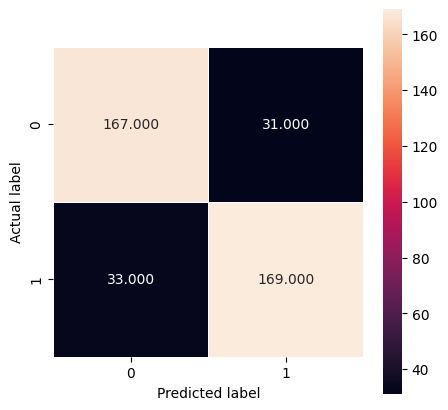

In [95]:
cm = confusion_matrix(y_test, clf_lr.fit(X_train,y_train).predict(X_test))
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion matrix:")
plt.savefig('svm_confusion_matrix.png')
plt.savefig('log_reg_confusion_matrix.png')


### <font color='orange'>LightGBM</font>

In [66]:
from flaml.default import LGBMClassifier

clf_lgbm = LGBMClassifier(random_state=42)
clf_lgbm.fit(X_train, y_train)


LGBMClassifier(colsample_bytree=0.5157078343718623,
               learning_rate=0.0016660662914022302, max_bin=255,
               min_child_samples=29, n_estimators=2541, num_leaves=1667,
               reg_alpha=0.045792841240713165, reg_lambda=0.0012362651138125363,
               verbose=-1)

In [67]:
evaluate_model(clf_lgbm,X_train,X_test,y_train,y_test,'LightGBM + Standard dataset')
evaluate_model(clf_lgbm,X_train_ext,X_test_ext,y_train,y_test,'LightGBM + Extended dataset')
evaluate_model(clf_lgbm,X_train_svd,X_test_svd,y_train,y_test,'LightGBM + SVD dataset')
evaluate_model(clf_lgbm,X_train_spca,X_test_spca,y_train,y_test,'LightGBM + Sparse PCA dataset')


Results for LightGBM + Standard dataset model are: accuracy_test = 0.8125
Results for LightGBM + Extended dataset model are: accuracy_test = 0.805
Results for LightGBM + SVD dataset model are: accuracy_test = 0.7525
Results for LightGBM + Sparse PCA dataset model are: accuracy_test = 0.6525


In [68]:
results

,model,best_params,train_score_acc,cross_val_score_acc,test_score_acc,train_score_auc,cross_val_score_auc,test_score_auc
0,Logistic Regression + Standard dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",1.000000,0.846250,0.8400,1.000000,0.923507,0.840034
1,Logistic Regression + Extended dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",1.000000,0.846875,0.8375,1.000000,0.923108,0.837559
2,Logistic Regression + SVD dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.836875,0.795000,0.7750,0.836860,0.876748,0.775228
3,Logistic Regression + Sparse PCA dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.681250,0.678750,0.6400,0.681195,0.725722,0.640714
4,LightGBM + Standard dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.998750,0.820000,0.8125,0.998747,0.898491,0.812656
5,LightGBM + Extended dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.999375,0.821250,0.8050,0.999373,0.896295,0.805181
6,LightGBM + SVD dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",1.000000,0.765625,0.7525,1.000000,0.853326,0.752850
7,LightGBM + Sparse PCA dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.999375,0.643750,0.6525,0.999377,0.680972,0.653540


Confusion matrix:


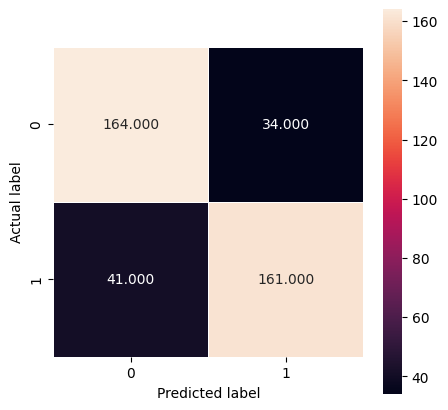

In [94]:
cm = confusion_matrix(y_test, clf_lgbm.fit(X_train,y_train).predict(X_test))
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion matrix:")
plt.savefig('lgbm_confusion_matrix.png')


#### <font color='orange'>Feature Importance</font>

<Axes: >

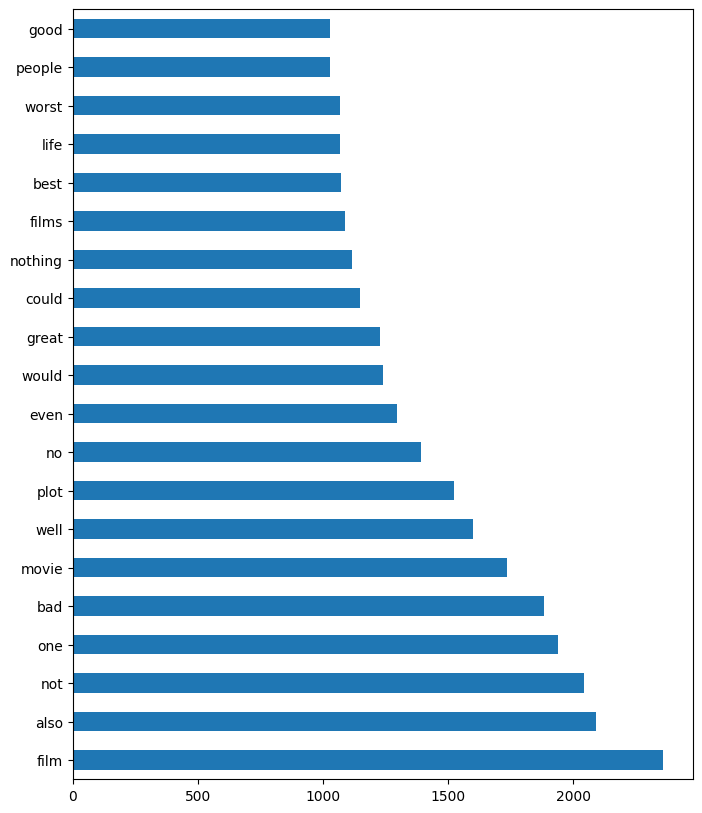

In [70]:
feat_imp = pd.Series(clf_lgbm.fit(X_train,y_train).feature_importances_, index=cv.get_feature_names_out())
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

<Axes: >

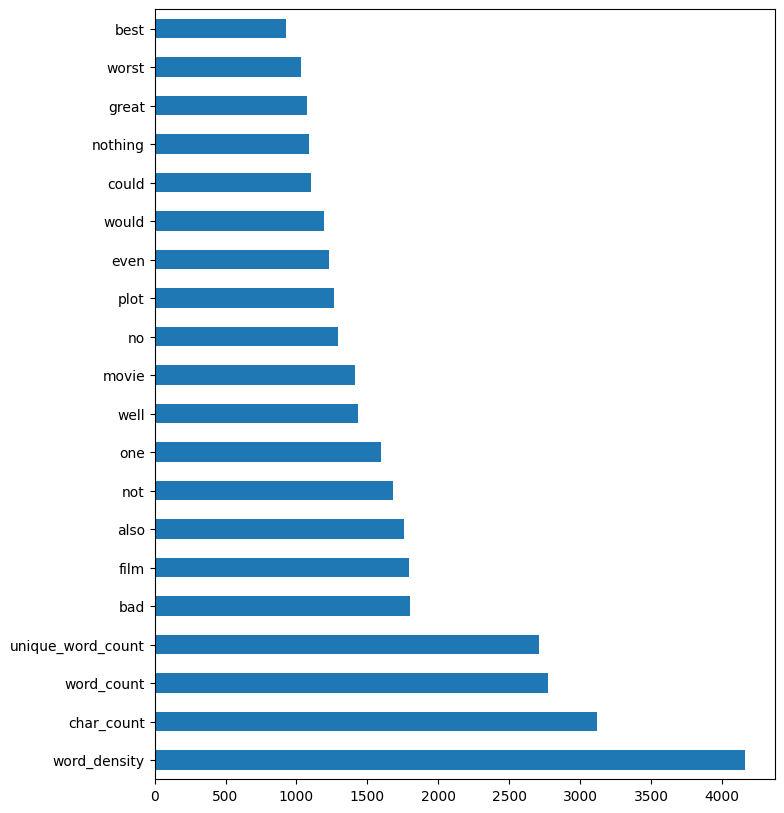

In [76]:
feat_imp_ext = pd.Series(clf_lgbm.fit(X_train_ext,y_train).feature_importances_, index=np.append(cv.get_feature_names_out(), sc.get_feature_names_out()))
feat_imp_ext.nlargest(20).plot(kind='barh', figsize=(8,10))

###  <font color='orange'>SVM</font>

In [86]:
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]

svm = SVC(random_state = 42)
grid_search_svm = GridSearchCV(estimator = svm,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search_svm.fit(X_train,y_train)

clf_svm = grid_search_svm.best_estimator_

In [87]:
clf_svm.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [88]:
evaluate_model(clf_svm,X_train,X_test,y_train,y_test,'SVM + Standard dataset')
evaluate_model(clf_svm,X_train_ext,X_test_ext,y_train,y_test,'SVM+ Extended dataset')
evaluate_model(clf_svm,X_train_svd,X_test_svd,y_train,y_test,'SVM + SVD dataset')
evaluate_model(clf_svm,X_train_spca,X_test_spca,y_train,y_test,'SVM + Sparse PCA dataset')

Results for SVM + Standard dataset model are: accuracy_test = 0.8275
Results for SVM+ Extended dataset model are: accuracy_test = 0.825
Results for SVM + SVD dataset model are: accuracy_test = 0.7675
Results for SVM + Sparse PCA dataset model are: accuracy_test = 0.64


In [100]:
results

,model,best_params,train_score_acc,cross_val_score_acc,test_score_acc,train_score_auc,cross_val_score_auc,test_score_auc
0,Logistic Regression + Standard dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",1.000000,0.846250,0.8400,1.000000,0.923507,0.840034
1,Logistic Regression + Extended dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",1.000000,0.846875,0.8375,1.000000,0.923108,0.837559
2,Logistic Regression + SVD dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.836875,0.795000,0.7750,0.836860,0.876748,0.775228
3,Logistic Regression + Sparse PCA dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.681250,0.678750,0.6400,0.681195,0.725722,0.640714
4,LightGBM + Standard dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.998750,0.820000,0.8125,0.998747,0.898491,0.812656
5,LightGBM + Extended dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.999375,0.821250,0.8050,0.999373,0.896295,0.805181
6,LightGBM + SVD dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",1.000000,0.765625,0.7525,1.000000,0.853326,0.752850
7,LightGBM + Sparse PCA dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.999375,0.643750,0.6525,0.999377,0.680972,0.653540
9,SVM + Standard dataset,"{'C': 1, 'break_ties': False, 'cache_size': 20...",1.000000,0.835625,0.8275,1.000000,0.913905,0.827608
10,SVM+ Extended dataset,"{'C': 1, 'break_ties': False, 'cache_size': 20...",1.000000,0.832500,0.8250,1.000000,0.912811,0.825083


Confusion matrix:


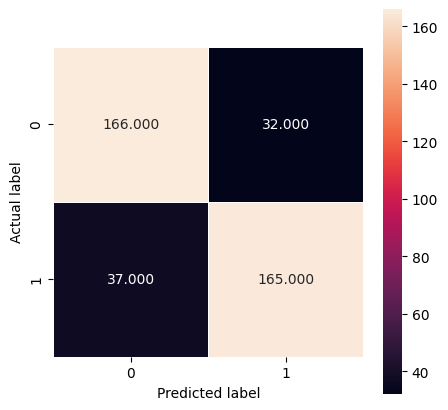

In [96]:
cm = confusion_matrix(y_test, clf_svm.fit(X_train,y_train).predict(X_test))
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion matrix:")
plt.savefig('svm_confusion_matrix.png')

In [102]:
results

,model,best_params,train_score_acc,cross_val_score_acc,test_score_acc,train_score_auc,cross_val_score_auc,test_score_auc
0,Logistic Regression + Standard dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",1.000000,0.846250,0.8400,1.000000,0.923507,0.840034
1,Logistic Regression + Extended dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",1.000000,0.846875,0.8375,1.000000,0.923108,0.837559
2,Logistic Regression + SVD dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.836875,0.795000,0.7750,0.836860,0.876748,0.775228
3,Logistic Regression + Sparse PCA dataset,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.681250,0.678750,0.6400,0.681195,0.725722,0.640714
4,LightGBM + Standard dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.998750,0.820000,0.8125,0.998747,0.898491,0.812656
5,LightGBM + Extended dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.999375,0.821250,0.8050,0.999373,0.896295,0.805181
6,LightGBM + SVD dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",1.000000,0.765625,0.7525,1.000000,0.853326,0.752850
7,LightGBM + Sparse PCA dataset,"{'boosting_type': 'gbdt', 'class_weight': None...",0.999375,0.643750,0.6525,0.999377,0.680972,0.653540
9,SVM + Standard dataset,"{'C': 1, 'break_ties': False, 'cache_size': 20...",1.000000,0.835625,0.8275,1.000000,0.913905,0.827608
10,SVM+ Extended dataset,"{'C': 1, 'break_ties': False, 'cache_size': 20...",1.000000,0.832500,0.8250,1.000000,0.912811,0.825083


####  <font color='orange'>Saving models</font>

In [107]:
import joblib

joblib.dump(clf_lr, 'log_reg_model.pkl')
joblib.dump(clf_svm, 'svm_model.pkl')
joblib.dump(clf_lgbm, 'lgbm_model.pkl')


['svm_model.pkl']